In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

from tqdm import tqdm_notebook as tqdm
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Reader, Dataset, KNNWithMeans, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

np.random.seed(42)

# Link for download dataset and pickles:
https://drive.google.com/file/d/1Jc9EtHGI2rJFGbZpkzj1X7W6lkJx6Ndz/view?usp=sharing

# Building a recommender system 
### By Petyo Karatov



#### Agenda:
<ul style="list-style-type:square;">
  <li>What is a recommender system?</li>
  
  <li>The popularity model</li>
  <li>Content based filtering</li>
  <li>Recommender Systems with surprise</li>
</ul>

### The problem

<p>&nbsp;&nbsp;&nbsp;&nbsp; A Recommender System refers to a system that is capable of predicting the future preference of a set of items for a user, and recommend the top items. One key reason why we need a recommender system in modern society is that people have too much options to use from due to the prevalence of Internet. In the past, people used to shop in a physical store, in which the items available are limited. For instance, the number of books that can be placed in a bookstore depends on the size of that store. By contrast, nowadays, the Internet allows people to access abundant resources online. Goodreads, for example, has an enormous collection of books. Although the amount of available information increased, a new problem arose as people had a hard time selecting the items they actually want to see. This is where the recommender system comes in. This article will give you a brief introduction to tree typical ways for building a recommender system, The popularity model, Content based filtering and Collaborative filtering.</p>

### What is a recommender system?

<p>&nbsp;&nbsp;&nbsp;&nbsp;A recommender system or a recommendation system (sometimes replacing 'system' with a synonym such as platform or engine) is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. They are primarily used in commercial applications.</p>

### Our data and use case

&nbsp;&nbsp;&nbsp;&nbsp; We will be using a  <a href="https://github.com/zygmuntz/goodbooks-10k">book dataset</a>  found here. It contains 10k books and 6 mil reviews (scores 1, 5).

Our task is to take those ratings and suggest for each user new things to read based on his previous feedback.

Formally

Given * a set of users [U1, U2, …] * a set of possible elements [E1, E2, … ] * some prior interactions (relation) between Us and Es ( {seen, clicked, subscribed, bought} or a rating, or a feedback, etc..),

for a given user U, predict a list of top N elements from E such as U maximizes the defined relation.

As I’ve said, usually the relation is an something numeric, business defined ( amount of money, click-through-rates, churn, etc..)

### Loading the data

In [4]:
books = pd.read_csv("data/books.csv")
ratings = pd.read_csv("data/ratings.csv")
tags = pd.read_csv("data/tags.csv")
tags = tags.set_index('tag_id')
book_tags = pd.read_csv("data/book_tags.csv")

### Data exploration

This wrapped function tells the pandas library to display all the fields

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

Books are sorted by their popularity, as measured by number of ratings

In [6]:
display_all(books.head().T)

,0,1,2,3,4
book_id,1,2,3,4,5
goodreads_book_id,2767052,3,41865,2657,4671
best_book_id,2767052,3,41865,2657,4671
work_id,2792775,4640799,3212258,3275794,245494
books_count,272,491,226,487,1356
isbn,439023483,439554934,316015849,61120081,743273567
isbn13,9.78044e+12,9.78044e+12,9.78032e+12,9.78006e+12,9.78074e+12
authors,Suzanne Collins,"J.K. Rowling, Mary GrandPré",Stephenie Meyer,Harper Lee,F. Scott Fitzgerald
original_publication_year,2008,1997,2005,1960,1925
original_title,The Hunger Games,Harry Potter and the Philosopher's Stone,Twilight,To Kill a Mockingbird,The Great Gatsby


We have 10k books

In [7]:
len(books)

10000

Ratings are sorted chronologically, oldest first.

In [8]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [9]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

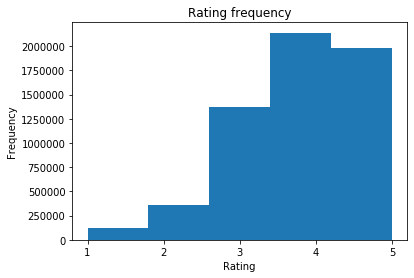

In [10]:
ratings.rating.hist(bins = 5, grid=False)
plt.xticks(np.arange(1, 6))
plt.title("Rating frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

It appears that 4 is the most popular rating. There are relatively few ones and twos.

In [11]:
len(ratings)

5976479

Most books have a few hundred reviews, but some have as few as eight.

In [12]:
reviews_per_book = ratings.groupby('book_id').book_id.apply(lambda x:len(x))
reviews_per_book.to_frame().describe()

,book_id
count,10000.000000
mean,597.647900
std,1267.289788
min,8.000000
25%,155.000000
50%,248.000000
75%,503.000000
max,22806.000000


## Popularity model

A common baseline approach is the Popularity model.

This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed.

As the popularity accounts for the “wisdom of the crowds”, it usually provides good recommendations, generally interesting for most people.

In [13]:
book_ratings = ratings.groupby('book_id').size().reset_index(name='users')
book_popularity = ratings.groupby('book_id')['rating'].sum().sort_values(ascending=False).reset_index()
book_popularity = pd.merge(book_popularity, book_ratings, how='inner', on=['book_id'])
book_popularity = pd.merge(book_popularity, books[['book_id', 'title', 'authors']], how='inner', on=['book_id'])
book_popularity = book_popularity.sort_values(by=['rating'], ascending=False)
book_popularity.head()

,book_id,rating,users,title,authors
0,1,97603,22806,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins
1,2,95077,21850,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré"
2,4,82639,19088,To Kill a Mockingbird,Harper Lee
3,18,70059,15855,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck"
4,25,69265,15304,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré"


Unfortunately, this strategy depends on what we rank on….
Let’s imagine we have another way to rank this list. (Above, books are sorted by their popularity, as measured by number of ratings.)
Let’s imagine we want to sort books by their average rating ( i.e. sum(ratings) / len(ratings))

In [14]:
book_popularity.rating = book_popularity.rating / book_popularity.users
book_popularity = book_popularity.sort_values(by=['rating'], ascending=False)
book_popularity.head(n=10)

,book_id,rating,users,title,authors
2108,3628,4.829876,482,The Complete Calvin and Hobbes,Bill Watterson
9206,7947,4.818182,88,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem"
6648,9566,4.768707,147,Attack of the Deranged Mutant Killer Monster S...,Bill Watterson
4766,6920,4.766355,214,The Indispensable Calvin and Hobbes,Bill Watterson
5702,8978,4.761364,176,The Revenge of the Baby-Sat,Bill Watterson
3904,6361,4.760456,263,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson
4228,6590,4.757202,243,The Authoritative Calvin and Hobbes: A Calvin ...,Bill Watterson
2695,4483,4.747396,384,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson
3627,3275,4.736842,285,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré"
1579,1788,4.728528,652,The Calvin and Hobbes Tenth Anniversary Book,Bill Watterson


?! Maybe this Bill Watterson pays people for good reviews..

This of course is insufficient advice for good books. Title fanatics may give high scores for unknown books. Since they are the only ones that do reviews, the books generally get good scores.

# Content based filtering

The aim of this approach is to group similar object together and recommend new objects from the same categories that the user already purchased

We already have tags for books in this dataset, let’s use them!

In [15]:
def get_tag_name(tag_id):
    return {word for word in tags.loc[tag_id].tag_name.split('-') if word}

get_tag_name(20000)

{'in', 'midnight', 'paris'}

def get_tag_name(tag_id):
    return {word for word in tags.loc[tag_id].tag_name.split('-') if word}

get_tag_name(20000)

We’re going to accumulate all the tags of a book in a single datastructure

In [16]:
# book_tags_dict = dict()
# for book_id, tag_id, _ in tqdm(book_tags.values):
#     tags_of_book = book_tags_dict.setdefault(book_id, set()) 
#     tags_of_book |= get_tag_name(tag_id)

In [17]:
# pickle.dump(book_tags_dict, open("book_tags_dict.p", "wb" ))

In [18]:
book_tags_dict = pickle.load(open( "book_tags_dict.p", "rb" ))

In [19]:
len(book_tags_dict)

10000

Let’s see the tags for one book

In [20]:
" ".join(book_tags_dict[105])

'philosophy novel series unread novels short i audiobooks all book e favourites my future sf fantascienza re scanned classic frank and paperback default science ficción books shelfari read speculative library ebooks audiobook audible chronicles finished politics general epic own herbert fiction calibre it fi to adult religion home currently sci american fantasy dune place ficcion 20th imaginary s time scifi literature bought classics ciencia century sff up audio space f english ebook kindle on bookshelf owned 1980s adventure opera not stories get reading buy in gave favorites sciencefiction'

And the book is…

In [21]:
books.loc[books.goodreads_book_id == 105][['book_id', 'title', 'authors']]

,book_id,title,authors
2816,2817,Chapterhouse: Dune (Dune Chronicles #6),Frank Herbert


There are two types of ids in this dataset: goodreads_book_id and book_id we will make two dicts to switch from one to the other

In [22]:
goodread2id = {goodreads_book_id: book_id for book_id, goodreads_book_id in books[['book_id', 'goodreads_book_id']].values}
id2goodread = dict(zip(goodread2id.values(), goodread2id.keys()))

id2goodread[2817], goodread2id[105]

(105, 2817)

Then we’re going to do convert the tags into a numpy plain array that we aim to process later. The row position of a tag should match the book_id. Because these start from 1, we will add a DUMMY padding element.

In [23]:
np_tags = np.array(sorted([[0, "DUMMY"]] + [[goodread2id[id], " ".join(tags)] for id, tags in book_tags_dict.items()]))
np_tags[:5]

array([['0', 'DUMMY'],
       ['1',
        '2011 2010 novel series games novels of i audiobooks faves survival club all favourite teen book e favourites completed my dystopias future sf distopian re suspense thriller default triangle once more the trilogy science books shelfari read speculative library ebooks audiobook finished star 5 stars own reads fiction than romance reread hunger it fi reviewed to adult apocalyptic post collins currently sci coming age fantasy favorite time lit scifi dystopian contemporary drama audio 2013 suzanne english ebook kindle owned distopia adventure borrowed 2012 young ya action love favs reading buy loved in dystopia futuristic favorites 2014'],
       ['2',
        'magic novel series 2016 novels 2017 i audiobooks witches faves grade all favourite teen favourites paranormal my jk re supernatural classic default once more children science british shelf books wizards shelfari read library urban audiobook friendship 5 stars own reads fiction mystery than

Next up we want to process the tags but if you look closely there are many words that have the same meaning but are slighly different (because of the context in which they are used).

We’d like to normalize them as much as possible so as to keep the overall vocabulary small.

This process can be accomplished through stemming and lemmatization. Let me show you an example:

In [24]:
stemmer = PorterStemmer()
stemmer.stem('autobiographical')

'autobiograph'

Lemmatisation is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word’s lemma, or dictionary form.

Stamming, is the process of reducing inflected words to their word stem, base or root form—generally a written word form.

In [25]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stm = PorterStemmer()
    def __call__(self, doc):
        return [self.stm.stem(self.wnl.lemmatize(t)) for t in word_tokenize(doc)]

After this we’re ready to process the data.

We will build a sklearn pipeline to process the tags.

We will first be using a tf-idf metric customized to tokenize words with the above implemented Lemmer and Stemmer class. Then we will use a StandardScaler transform to make all the values in the resulting matrix [0, 1] bound.

In [26]:
# p = Pipeline([
#     ('vectorizer', TfidfVectorizer(
#         tokenizer=LemmaTokenizer(),
#         strip_accents='unicode',
#         ngram_range=(1, 1),
#         max_features=1000,
#         min_df=0.005,
#         max_df=0.5,
#     )),
#     ('normalizer', StandardScaler(with_mean=False))
# ])
# trans = p.fit_transform(np_tags[:,1])

In [27]:
# pickle.dump(p, open("p.p", "wb" ))

In [28]:
p = pickle.load(open( "p.p", "rb" ))

In [29]:
# pickle.dump(trans, open("trans.p", "wb" ))

In [30]:
trans = pickle.load(open("trans.p", "rb" ))

In [31]:
trans.shape

(10001, 1000)

In [32]:
trans

<10001x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 494913 stored elements in Compressed Sparse Row format>

After this point, the trans variable contains a row for each book, each suck row corresponds to a 1000 dimensional array. Each element of that 1000, is a score for the most important 1000 words that the TfidfVectorizer decided to keep (1000 words chosen from all the book tags provided).

This is the vectorized representation of the book, the vector contains (many 0 values) the most important (cumulated for all users) words with which people tagged the books.

Next up, let’s see how many users do we have and let’s extract them into a single list.

In [33]:
users = ratings.set_index('user_id').index.unique().values
len(users)

53424

That’s how we get all the book ratings of a single user

In [34]:
ratings.loc[ratings.user_id == users[0]][['book_id', 'rating']].head()

,book_id,rating
0,258,5
75,268,3
76,5556,3
77,3638,3
78,1796,5


We’ll actually write a function for this because it’s rather obscure. We want all the book_ids that the user rated, along with the given rating for each book.

In [35]:
def books_and_ratings(user_id):
        books_and_ratings_df = ratings.loc[ratings.user_id == user_id][['book_id', 'rating']]
        u_books, u_ratings = zip(*books_and_ratings_df.values)
        return np.array(u_books), np.array(u_ratings)
    
u_books, u_ratings = books_and_ratings(users[0])
u_books.shape, trans[u_books].shape

((117,), (117, 1000))

We then multiply the book’s ratings with the features of the book, to boost the features importance for this user, then add everything together into a single user specific feature vector.

In [36]:
user_vector = (u_ratings * trans[u_books]) / len(u_ratings)
user_vector.shape

(1000,)

If we get all the features of a book, scale each book by the user’s ratings and then do a mean on all the scaled book features as above, we actually obtain a condensed form of that user’s preferences.

So doing the above we just obtained a user_vector, a 1000 dimensional vector that expresses what the user likes, by combining his prior ratings on the books he read with the respected book_vectors.

In [37]:
def get_user_vector(user_id):
    u_books, u_ratings = books_and_ratings(user_id)
    u_books_features = trans[u_books]
    u_vector = (u_ratings * u_books_features) / len(u_ratings)
    return u_vector
    
def get_user_vectors():
    user_vectors = np.zeros((len(users), 1000))
    for user_id in tqdm(users[:1000]):
        u_vector = get_user_vector(user_id)
        user_vectors[user_id, :] = u_vector
    return user_vectors

user_vectors = get_user_vectors()


The pipeline transformation also keeps the most important 1000 words. Let’s see a sample of them now..

In [38]:
trans_feature_names = p.named_steps['vectorizer'].get_feature_names()
np.random.permutation(np.array(trans_feature_names))[:100]

array(['kid', 'purchas', 'quirki', 'novella', 'god', 'paper', 'mysteri',
       'junior', 'steami', 'best', 'serial', 'all', 'need', 'woman',
       'unread', 'terjemahan', 'disturb', 'suspens', 'requir', 'environ',
       'lewi', 'calibr', 'food', 'king', 'class', 'cookeri', 'art', 'you',
       'than', 've', 'fantascienza', 'biblioteca', 'multipl', 'jack',
       'folklor', 'childhood', 'pdf', 'math', 'terror', 'abandon',
       'essay', 'apocalyps', 'enemi', 'work', 'easi', 'disabl', 'triangl',
       'mf', 'help', 'social', 'love', 'supernatur', 'dean', 'manga',
       '20', '2005', 'mother', '1900', 'color', 'shelf', 'dystopia', '6',
       'leadership', 'clasico', 'middl', 'philosoph', 'occult', 'stori',
       'african', 'learn', 'assassin', 'irish', 'medic', 'r', 'drop',
       'dragon', 'nonfict', '2017', 'medal', 'elementari', 'paperback',
       'adopt', 'digit', 'adventur', 'entrepreneurship', 'letteratura',
       'كتب', 'pov', 'refer', 'espionag', 'french', 'holiday', 'ki

Once we have the user_vectors computed, we want to show the most important 20 words for it.

In [39]:
user_id = 100

pd.DataFrame(
    sorted(
        zip(
            trans_feature_names, 
            user_vectors[user_id].flatten().tolist()
        ), 
        key=lambda x: -x[1]
    )[:20],
    columns=['token', 'relevance']
).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
token,philosoph,classic,translat,existenti,literatur,روايات,centuri,literari,european,philosophi,20th,1001,eastern,re,roman,you,die,letteratura,gilmor,rori
relevance,8.48307,7.491,7.08973,7.03154,6.35261,6.34232,6.10287,5.7881,5.74691,5.6679,5.31838,5.28018,5.1303,5.10013,5.05865,5.05788,4.86209,4.75165,4.74578,4.74578


The last piece of the puzzle at this stage is making a link between the book_vectors and the user_vectors.

Since both of them are computed on the same feature space, we simply need a distance metric that would rank a given user_vector to all the book_vectors.

One such metric is the cosine_similarity that we’re using bellow. It computes a distance between two n-dimensional vectors and returns a score between -1 and 1 where:

<ul style="list-style-type:square;">
  <li>something close to -1 means that the vectors have opposite relations (e.g. comedy and drama)</li>
  <li>something close to 0 means that the vectors have no relation between them</li>
  <li>Tsomething close to 1 means that the vectors are quite similar</li>
</ul>
    
The code bellow will compute a recommendation for a single user.

In [40]:
user_id = 17292
cosine_similarities = cosine_similarity(np.expand_dims(user_vectors[user_id], 0), trans)
similar_indices = cosine_similarities.argsort().flatten()[-20:]
similar_indices

array([ 3339,  3337,  3321,  3322,  3323,  3324,  3325,  3326,  3327,
        3338,  3328,  3330,  3331,  3332,  3333,  3334,  3335,  3336,
        3329, 10000])

Which translates to the following books:

In [41]:
books.loc[books.book_id.isin(similar_indices)][['title', 'authors']]

,title,authors
3320,Pale Fire,Vladimir Nabokov
3321,The Lady and the Unicorn,Tracy Chevalier
3322,A Christmas Carol and Other Christmas Writings,"Charles Dickens, Michael Slater"
3323,One More Thing: Stories and Other Stories,B.J. Novak
3324,Men at Arms: The Play,"Terry Pratchett, Stephen Briggs"
3325,"Carpe Corpus (The Morganville Vampires, #6)",Rachel Caine
3326,The Shock of the Fall,Nathan Filer
3327,"Asylum (Asylum, #1)",Madeleine Roux
3328,The Heart Goes Last,Margaret Atwood
3329,"A Fistful of Charms (The Hollows, #4)",Kim Harrison


This approach gives way better predictions than the popularity model but, on the other hand, this relies on us having the content of the books (tags, book_tags, etc..) which we might not have, or might add a new level of complexity (parsing, cleaning, summarizing, etc…).

## Recommender Systems with surprise



First we will fet the sample of the data to reduce the dimensionality of the data set. Then explore it. 

In [42]:
# min_book_ratings = 150
# filter_books = ratings['book_id'].value_counts() > min_book_ratings
# filter_books = filter_books[filter_books].index.tolist()

# min_user_ratings = 150
# filter_users = ratings['user_id'].value_counts() > min_user_ratings
# filter_users = filter_users[filter_users].index.tolist()

# df_new = ratings[(ratings['book_id'].isin(filter_books)) & (ratings['user_id'].isin(filter_users))]
# print('The original data frame shape:\t{}'.format(ratings.shape))
# print('The new data frame shape:\t{}'.format(df_new.shape))

In [43]:
df_new = ratings.sample(n=100000, random_state=1)

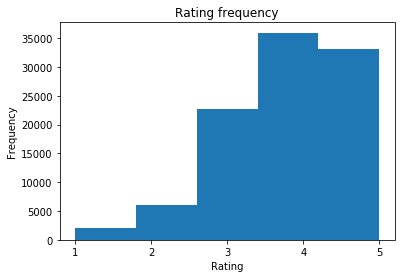

In [44]:
df_new.rating.hist(bins = 5, grid=False)
plt.xticks(np.arange(1, 6))
plt.title("Rating frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [45]:
users = df_new.set_index('user_id').index.unique().values
len(users)

44469

In [46]:
books_arr = df_new.set_index('book_id').index.unique().values
len(books_arr)

9535

In [47]:
len(df_new)

100000

In [48]:
df_combined = pd.merge(df_new, books, on = 'book_id')

To load a data set from the above pandas data frame, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [49]:
# Load the books dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new, reader)

In [50]:
trainset, testset = train_test_split(data, test_size=0.25)

#### Algorithms Based on K-Nearest Neighbours (k-NN)

The choice of algorithm for the recommender function depends on the technique you want to use. For the memory-based approaches, the algorithm that would fit the bill is <a href="https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNWithMeans">Centered k-NN</a> because the algorithm is very close to the centered cosine similarity formula. It is available in Surprise as KNNWithMeans.

To find the similarity, you simply have to configure the function by passing a dictionary as an argument to the recommender function. The dictionary should have the required keys, such as the following:
<ul>
    <li>name contains the similarity metric to use. Options are cosine, msd, pearson, or pearson_baseline. The default is msd.</li>
    <li>user_based is a boolean that tells whether the approach will be user-based or item-based. The default is True, which means the user-based approach will be used.</li>
    <li>min_support is the minimum number of common items needed between users to consider them for similarity. For the item-based approach, this corresponds to the minimum number of common users for two items.</li>
</ul>

You can check more information for similarity <a href="https://surprise.readthedocs.io/en/stable/similarities.html">here</a>.

#### Tuning the Algorithm Parameters

Surprise provides a GridSearchCV class analogous to <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a>. from scikit-learn.

With a dict of all parameters, GridSearchCV tries all the combinations of parameters and reports the best parameters for any accuracy measure

For example, you can check which similarity metric works best for your data in memory-based approaches:

Use the new parameters with the train data

In [51]:
# sim_options = {
#     "name": ["msd", "cosine", "pearson_baseline"],
#     "min_support": [3, 4, 5, 7],
#     "user_based": [False],
# }

# param_grid = {"sim_options": sim_options}

# gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=5, refit=True)
# gs.fit(data)

In [52]:
# pickle.dump(gs, open("gs.p", "wb" ))
# gs = pickle.load(open( "gs.p", "rb" ))

In [53]:
# print(gs.best_score["rmse"])
# print(gs.best_params["rmse"])
# # algo = gs.best_estimator['rmse']

After the GridSearch best estimator is {'sim_options': {'name': 'msd', 'min_support': 7, 'user_based': False}} <br/>
best score: 1.0118589513557084</b>

In [54]:
algoKNN = KNNWithMeans(sim_options={'name': 'msd', 'min_support': 7, 'user_based': False})
algoKNN.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [55]:
# The model fit faster and the pickle is very big. So no need to make pickle :) 
# pickle.dump(algoKNN, open("algoKNN.p", "wb" ))
# algoKNN = pickle.load(open( "algoKNN.p", "rb" ))

In [56]:
test_pred = algoKNN.test(testset)
print("KNNWithMeans : Test Set")
accuracy.rmse(test_pred, verbose=True)

KNNWithMeans : Test Set
RMSE: 1.0177


1.0177219015004995

#### How to compute precision@k and recall@k

Here is an example where we compute Precision@k and Recall@k for each user:

Precision@k={Recommended items that are relevant}/{Recommended items}
Recall@k={Recommended items that are relevant}/{Relevant items}

An item is considered relevant if its true rating r<sub>ui</sub>
is greater than a given threshold. An item is considered recommended if its estimated rating r<sup>^</sup><sub>ui</sub> is greater than the threshold, and if it is among the k highest estimated ratings.

Relevant items are already known in the data set<br/>
Relevant item: Has a True/Actual rating >= 3.5<br/>
Irrelevant item: Has a True/Actual rating < 3.5<br/>Recommended items are generated by recommendation algorithm<br/>
Recommended item: has a predicted rating >= 3.5<br/>
Not recommended item: Has a predicted rating < 3.5

In [57]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [58]:
precisions, recalls = precision_recall_at_k(test_pred, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))


0.8991576961304559
0.5541500311652432


In [59]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [60]:
# Let's take a look at the best and worst predictions of the algorithm to see if there is something interesting.
# You can see that books with more rateings gives better results.
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4407,48091,6673,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",1,2,0.0
8492,7203,2345,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",1,1,0.0
18605,12976,2712,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",2,6,0.0
18609,13096,8531,3.0,3.0,"{'actual_k': 0, 'was_impossible': False}",3,1,0.0
18618,39443,7344,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",3,4,0.0
3492,21120,2721,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",3,8,0.0
1369,44704,4657,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",1,2,0.0
18630,1323,1706,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",2,21,0.0
18635,45836,9773,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",2,3,0.0
18570,22263,5232,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",3,2,0.0


In [61]:
# Now, let's look at the prediction with the biggest error
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
11507,20675,6084,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,2,4.0
17958,30793,1409,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,2,4.0
2937,51456,6564,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",1,1,4.0
11078,3691,7775,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,2,4.0
908,39411,5809,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",2,1,4.0
336,18062,4367,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",1,1,4.0
10347,33369,9401,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,1,4.0
14553,46104,6564,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",1,1,4.0
11158,7742,2589,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,1,4.0
6121,41519,4958,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,1,4.0


Lets see recommendations for one user. For example we will take user 10277 and will display the books with max rating.

### Matrix Factorization

While user‐based or item‐based collaborative filtering methods are simple and intuitive, Matrix Factorization techniques are usually more effective because they allow us to discover the latent features underlying the interactions between users and items. We don’t actually know these latent features. The famous singular vector decomposition (<a href="https://en.wikipedia.org/wiki/Singular_value_decomposition">SVD</a>) shown here employs the use of gradient descent to minimize the squared error between predicted rating and actual rating, eventually getting the best model.


http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf

Again, Surprise has done the hard plumbing for you, and all is needed is to utilize the SVD() class.

See http://surprise.readthedocs.io/en/stable/matrix_factorization.html for more information.

We use GridSearchCV to do a brute-force search for the hyper-parameters for the SVD algorithm. After doing a cross validation that these are indeed the best values, we use these hyper-parameter values to train on the training set.

Eventually, we evaluate the model on the test set.

We can use GridSearchCV to check which values for the following factors work best:
<ul>
    <li><b>n_factors</b> - The number of factors. Default is 100</li>
    <li><b>n_epochs</b> is the number of iterations of SGD, which is basically an iterative method used in Statistics to minimize a function.</li>
    <li><b>lr_all</b> is the learning rate for all parameters, which is a parameter that decides how much the parameters are adjusted in each iteration.</li>
    <li><b>reg_all</b> is the regularization term for all parameters, which is a penalty term added to prevent overfitting.</li>
</ul>

In [62]:
# param_grid = {'n_factors': [100, 110], 'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.008],
#               'reg_all': [0.15, 0.4, 0.6]}
# gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, refit=True)
# gs_svd.fit(data)

In [63]:
# pickle.dump(gs_svd, open("gs_svd.p", "wb" ))
# gs_svd = pickle.load(open( "gs_svd.p", "rb" ))

In [64]:
# algo = gs_svd.best_estimator['rmse']
# print(gs_svd.best_score['rmse'])
# print(gs_svd.best_params['rmse'])

After GridSerch best parametars are {'sim_options': {'n_factors': 100, 'n_epochs': 15, 'lr_all': 0.008, 'reg_all': 0.4} with best score rmse 0.9534399619493493

In [65]:
SVD_algo = SVD(n_factors=100, n_epochs=15, lr_all=0.008, reg_all=0.4)
SVD_algo.fit(trainset)

In [66]:
# pickle.dump(SVD_algo, open("SVD_algo.p", "wb" ))
# SVD_algo = pickle.load(open( "SVD_algo.p", "rb" ))

In [67]:
# Use the new parameters with the train data

test_pred_SVD = SVD_algo.test(testset)
print("SVD : Test Set")
print(accuracy.rmse(test_pred_SVD, verbose=True))

SVD : Test Set
RMSE: 0.9600
0.9600069480318091


In [68]:
precisions, recalls = precision_recall_at_k(test_pred_SVD, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))


0.913485284951399
0.5834436751402435


To inspect our predictions in details, we are going to build a pandas data frame with all the predictions. 

In [69]:
df = pd.DataFrame(test_pred_SVD, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [70]:
# Let's take a look at the best and worst predictions of the algorithm to see if there is something interesting
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
14300,3571,7127,4.0,4.000025,{'was_impossible': False},1,0,0.000025
1428,17292,440,4.0,4.000104,{'was_impossible': False},4,37,0.000104
2216,36623,408,4.0,3.999868,{'was_impossible': False},4,31,0.000132
19850,11972,124,4.0,4.000143,{'was_impossible': False},3,81,0.000143
17425,50998,1743,4.0,4.000195,{'was_impossible': False},1,10,0.000195
8484,20670,2759,4.0,4.000224,{'was_impossible': False},0,2,0.000224
21394,41699,2997,4.0,4.000259,{'was_impossible': False},2,8,0.000259
22262,6000,54,4.0,4.000282,{'was_impossible': False},2,153,0.000282
958,1119,9601,4.0,4.000298,{'was_impossible': False},0,2,0.000298
11029,12260,76,4.0,4.000311,{'was_impossible': False},0,98,0.000311


In [71]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
11946,16450,27,1.0,4.278038,{'was_impossible': False},0,148,3.278038
24167,49298,992,1.0,4.288365,{'was_impossible': False},2,15,3.288365
2797,6460,1322,1.0,4.326167,{'was_impossible': False},3,15,3.326167
19805,40387,953,1.0,4.336785,{'was_impossible': False},1,12,3.336785
10094,42798,289,1.0,4.347171,{'was_impossible': False},2,52,3.347171
24792,49914,953,1.0,4.371176,{'was_impossible': False},1,12,3.371176
8768,44850,80,1.0,4.374835,{'was_impossible': False},1,72,3.374835
17190,44862,2795,1.0,4.393601,{'was_impossible': False},0,11,3.393601
1641,30777,792,1.0,4.457458,{'was_impossible': False},2,18,3.457458
18494,27645,389,1.0,4.485660,{'was_impossible': False},3,33,3.485660


### Predict top 10 items of a user

In [72]:
user = 17292

In [73]:
df_combined[(df_combined['user_id'] == user)]['title']

36368             Fall of Giants (The Century Trilogy, #1)
40752    Mennonite in a Little Black Dress: A Memoir of...
52052    Born to Run: A Hidden Tribe, Superathletes, an...
68123    The Golem and the Jinni (The Golem and the Jin...
85597      Genghis Khan and the Making of the Modern World
Name: title, dtype: object

In [74]:
def predict_top10(user, alg):
    user_book_ids = df_combined[(df_combined['user_id'] == user)]['book_id'].tolist() 
    unique_book_ids = df_combined['book_id'].drop_duplicates().tolist() 
    unrated_book_ids = [x for x in unique_book_ids if x not in user_book_ids]
    pred = []
    for book in unrated_book_ids:
        predict = alg.predict(uid=user, iid=book)
        pred.append([predict.est, predict.iid])
    df = pd.DataFrame(pred, columns =['rating', 'book_id'])
    df = df.sort_values(by=['rating'], ascending=False).head(10)
    user_recommended_books = pd.merge(df, df_combined[['book_id', 'title', 'authors']], on = 'book_id')
    return user_recommended_books.drop_duplicates()

In [75]:
predict_top10(17292, SVD_algo)

,rating,book_id,title,authors
0,4.477538,1636,"Iron Kissed (Mercy Thompson, #3)",Patricia Briggs
14,4.433625,422,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling
47,4.386244,862,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson
69,4.379760,728,"Brown Bear, Brown Bear, What Do You See?","Bill Martin Jr., Eric Carle"
84,4.378571,192,The Name of the Wind (The Kingkiller Chronicle...,Patrick Rothfuss
140,4.376808,1584,Rosencrantz and Guildenstern Are Dead,"Tom Stoppard, Henry Popkin"
163,4.369316,2907,"Good Night, Gorilla",Peggy Rathmann
172,4.358283,1394,"White Night (The Dresden Files, #9)",Jim Butcher
191,4.357791,3078,The Paper Bag Princess,"Robert Munsch, Michael Martchenko"
200,4.350713,2795,Archer's Voice,Mia Sheridan


In [76]:
predict_top10(17292, algoKNN)

,rating,book_id,title,authors
0,5.0,8560,What the Bleep Do We Know!?: Discovering the E...,"William Arntz, Betsy Chasse, Mark Vicente"
2,5.0,2729,Twenty Love Poems and a Song of Despair,"Pablo Neruda, W.S. Merwin, Cristina García"
6,5.0,8014,"Psycho-Cybernetics, A New Way to Get More Livi...",Maxwell Maltz
8,5.0,3451,Letters to a Young Poet,"Rainer Maria Rilke, Reginald Snell, Franz Xave..."
16,5.0,7299,"All-Star Superman, Vol. 2","Grant Morrison, Frank Quitely"
17,5.0,5339,"Hunter x Hunter, Vol. 01 (Hunter x Hunter, #1)","Yoshihiro Togashi, 冨樫 義博"
18,5.0,8602,Mouse Paint,Ellen Stoll Walsh
20,5.0,5901,Ancillary Mercy (Imperial Radch #3),Ann Leckie
21,5.0,4744,Games People Play,Eric Berne
23,5.0,9281,"Agamemnon (Oresteia, #1)","Aeschylus, Judith Affleck, Philip de May, Patr..."


## Conclusion

As you saw in this article, there are a handful of methods one could use to build a recommendation system. The data scientist is tasked with finding and fine-tuning the methods that match the data better.

We’ve shown how to implement 3 recommendation engine models:

    Popularity model
    Content based model
    Recomendation with Surprise
    
    
All methods returns different results, but SVD should be more acurate than KNN.